In [2]:
import os
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
from europa_seismo.europa_seismo import rayleigh, minos
from scipy.interpolate import interp1d
from pymc.Matplot import plot
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline

### Read sample dispersion data

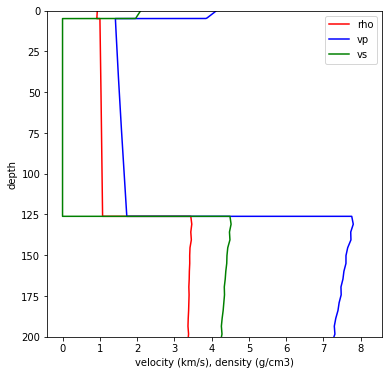

100


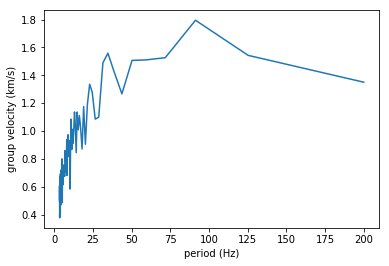

In [4]:
#data_obs = np.loadtxt('../data/dispersion_curves/disp_icehot20_test.dat')
data_obs = np.loadtxt('../data/dispersion_curves/icehot_5km_FTAN.dat')
f_obs = data_obs[:,0]
vel_obs = data_obs[:,1]

rayleigh.plot_deck_model('../data/models/icehot_5km_prem.txt')

plt.plot(f_obs,vel_obs)
plt.xlabel('period (Hz)')
plt.ylabel('group velocity (km/s)')
plt.savefig('fig1.pdf',format='pdf',transparent='True')
print len(f_obs)

### Define Monte Carlo model

In [5]:
#get current working directory
cwd = os.getcwd()

#shear velocity of ice is assumed to be 2.0 km /s
vs_i = 2.0

#define stochastic variables
h_r = pm.Uniform('h_r',lower=0.0,upper=2.0) #regolith thickness
h_i = pm.Uniform('h_i',lower=h_r,upper=50.0) #ice thickness
vs_r = pm.Uniform('vs_r',lower=0.5,upper=3.5) #regolith shear velocity
gcarc = pm.Uniform('gcarc',lower=10.0,upper=50.0) # distance from event

#define data variance
sigma = 0.1
tau = np.power(sigma,-2)

#define forward model
@pm.deterministic
def mu(h_r=h_r, vs_r=vs_r, h_i=h_i, vs_i=vs_i, gcarc=gcarc):
    
    #write current model
    h2o_thickness = 1565000.0 - 1438875
    ocean_thickness = h2o_thickness - (h_i*1000.0)
    layers = rayleigh.make_layers_dict(regolith_thickness = h_r*1000.0,
                                       ice_thickness = h_i*1000.0,
                                       ocean_thickness = ocean_thickness,
                                       vp_regolith=4000.,
                                       vs_regolith=vs_r*1000.0,
                                       vs_ice=vs_i*1000.0)
    
    rayleigh.write_deck_model(layers,output_model='europa.deck',
                              base_model=cwd+'/../data/models/'+'icehot_20km_simple.txt')

    
    #run current model
    modesfile='modes.out'
    eigfile='eig.out'
    eps=1e-10
    wgrav=1.315
    jcom=3
    lmin=0
    lmax=1000
    wmin=0.1
    wmax=100.0 #10 s period
    nmin=0.0                                                                    
    nmax=0.0

    modelfile='europa.deck'
    minos.main(modelfile,modesfile,eigfile,eps,wgrav,jcom,lmin,lmax,wmin,wmax,nmin,nmax)
    f = np.genfromtxt('modes.out')
    freq_mhz = f[:,4]
    group_vel = f[:,6] #group velocity
    
    # use delta to convert distpersion curves from velocity to time
    km_per_deg = 27.31
    group_time = (gcarc * km_per_deg) / group_vel
    
    
    
    #interpolate to observed frequencies
    freq_interp = interp1d(freq_mhz,group_vel,bounds_error=None,fill_value='extrapolate')
    vel_modeled = freq_interp(f_obs)
    
    return vel_modeled

#define likelyhood
y = pm.Normal('y', mu=mu, tau=tau, value=vel_obs, observed=True)

#inference
m = pm.Model([h_r,h_i,vs_r,vs_i,tau,y])
mc = pm.MCMC(m)
mc.sample(iter=2000,burn=1000)

/Users/rossmaguire/anaconda2/lib/python2.7/site-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 2001 of 2000 complete in 2813.6 sec

Plotting h_r
Plotting h_i
Plotting vs_r
Plotting vs_i


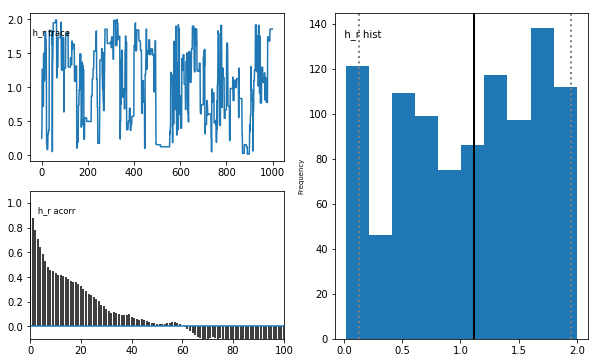

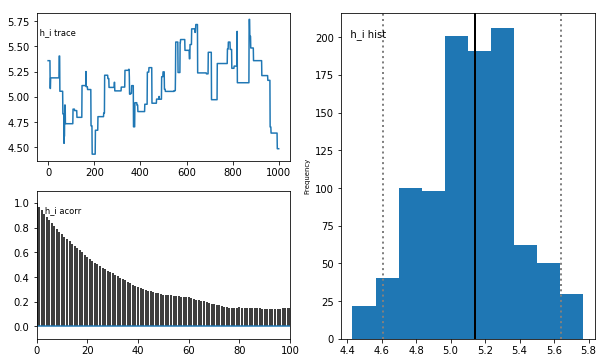

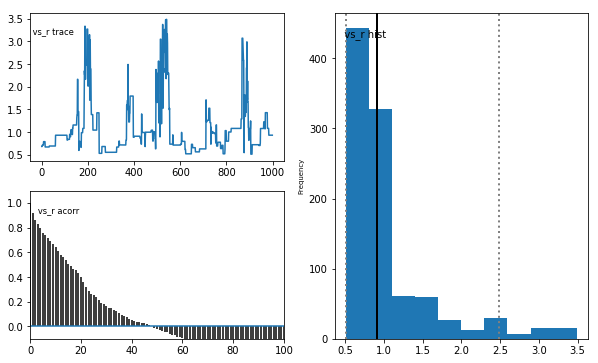

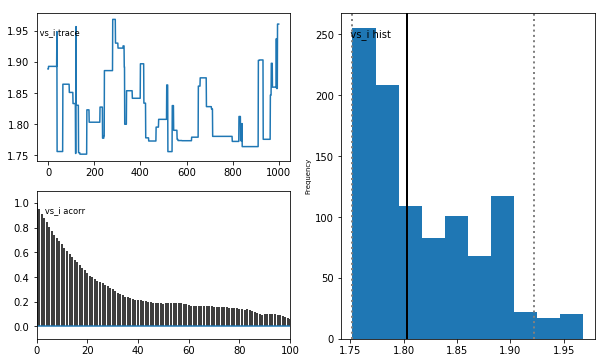

In [6]:
plot(mc)

In [8]:
h2o_thickness = 1565000.0 - 1438875
h_r_mean =  np.mean(h_r.trace())
h_i_mean =  np.mean(h_i.trace())
vs_r_mean =  np.mean(vs_r.trace())
vs_i_mean =  np.mean(vs_i.trace())
ocean_thickness = h2o_thickness - (h_i_mean*1000.0)

### Compare mean model with target model

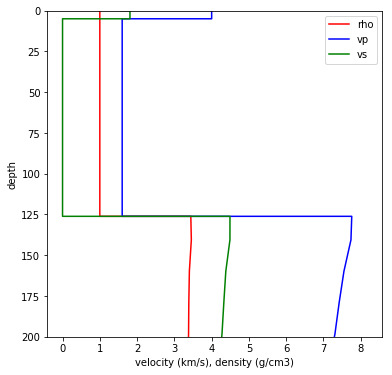

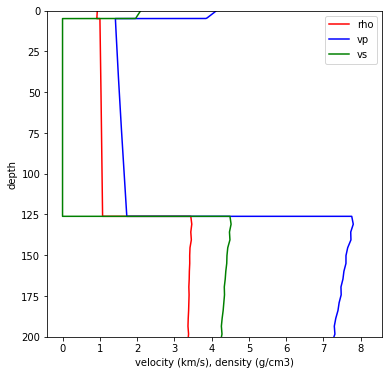

In [11]:
layers = rayleigh.make_layers_dict(regolith_thickness = h_r_mean*1000.0,
                                    ice_thickness = h_i_mean*1000.0,
                                    ocean_thickness = ocean_thickness,
                                    vp_regolith=4000.,
                                    vs_regolith=vs_r_mean*1000.0,
                                    vs_ice=vs_i_mean*1000.0)

rayleigh.write_deck_model(layers,output_model='europa_mean.deck',
                          base_model=cwd+'/../data/models/'+'icehot_20km_simple.txt')
rayleigh.plot_deck_model('europa_mean.deck')
#rayleigh.plot_deck_model('../data/models/icehot_20km_simple.txt')
rayleigh.plot_deck_model('../data/models/icehot_5km_prem.txt')

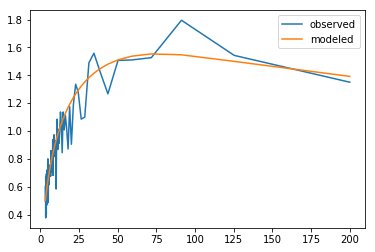

In [7]:
#run current model
modesfile='modes.out'
eigfile='eig.out'
eps=1e-10
wgrav=1.315
jcom=3
lmin=0
lmax=1000
wmin=0.1
wmax=100.0 #10 s period
nmin=0.0                                                                    
nmax=0.0

modelfile='europa_mean.deck'
minos.main(modelfile,modesfile,eigfile,eps,wgrav,jcom,lmin,lmax,wmin,wmax,nmin,nmax)
f = np.genfromtxt('modes.out')
freq_mhz = f[:,4]
group_vel = f[:,6] #group velocity
    
#interpolate to observed frequencies
freq_interp = interp1d(freq_mhz,group_vel,bounds_error=None,fill_value='extrapolate')
vel_modeled = freq_interp(f_obs)

plt.plot(f_obs,vel_obs,label='observed')
plt.plot(f_obs,vel_modeled,label='modeled')
plt.legend()
plt.show()

In [8]:
np.savetxt('grpvel_obs.dat',np.c_[f_obs,vel_obs],fmt='%3f')
np.savetxt('grpvel_modeled.dat',np.c_[f_obs,vel_modeled],fmt='%3f')